In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import cvxpy as cp
from math import floor
import random
from scipy.signal import fftconvolve
import heapq as hq
from tqdm import tqdm
from pprint import pprint

from model.constants import N
from model.allocations import solve, max_parrots

In [6]:
np.random.seed(1)
random.seed(1)

# Financials

In [7]:
from model.financials import planting_strategies

print("Strategy\tAnnual Yield (m^3/ha/y)\tRevenue ($/ha/y)")
print("--------\t--------------\t\t------------")
for s in planting_strategies:
    print(f"{s.name}\t{s.annual_yield_per_ha}\t\t\t{s.annual_revenue_per_ha}")

Strategy	Annual Yield (m^3/ha/y)	Revenue ($/ha/y)
--------	--------------		------------
Eucalyptus 25	20.0			500.0
Mahogany 100	5.0			6500.0
Mahogany 200	4.0			5200.0
Reserve	0.0			0.0


# Fire

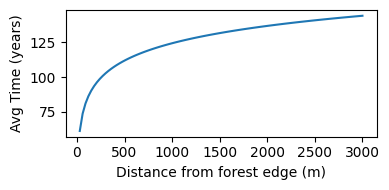

In [11]:
from model.fire import plot_interarrival, plot_log_risk, fire_avg_interarrival

x = np.linspace(30, 3000, 100)
plt.figure(figsize=(4, 2))
plt.plot(x, fire_avg_interarrival(x))

plt.ylabel('Avg Time (years)')
plt.xlabel('Distance from forest edge (m)')
plt.tight_layout()
plt.savefig("figures/fire_interarrival.png")

/Users/leoware/Documents/NS166/Assignment_1/model/fire.py:7: RuntimeWarning: divide by zero encountered in log
  return 18*np.log(dist)
/Users/leoware/Documents/NS166/Assignment_1/model/fire.py:28: RuntimeWarning: divide by zero encountered in log
  plt.contourf(np.log(annual_fire_risk), cmap="Reds", levels=100)


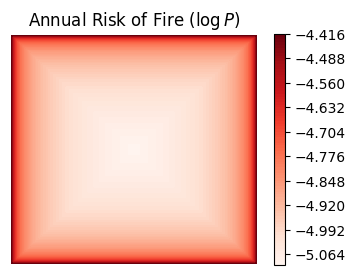

In [3]:
plot_log_risk()

In [87]:
G = 5
fire_state = np.zeros((G, G), dtype=bool)
wx = np.array([0])
wy = np.array([0])

fire_state = np.zeros((G, G), dtype=bool)
fire_state[wx, wy] = True
dist = flood_fill(wx, wy, shape=(G, G))

neighborhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

foo1 = fftconvolve(fire_state, neighborhood, mode='same')

# Allocations

In [4]:
allocations = solve().allocations
allocations

{'Eucalyptus 25': 210,
 'Mahogany 100': 1,
 'Mahogany 200': 28956,
 'Reserve': 761}

In [81]:
foo = np.zeros((6, 6))
foo[0, 0] = 1
bar = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])

baz = foo
for _ in range(2):
    baz = np.round(fftconvolve(baz, bar, mode='same'))

foo

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [12]:
print(planting_strategies[0].name)
min_euc = 120000/planting_strategies[0].annual_yield_per_ha
((173**2) - min_euc)/120


Eucalyptus 25


199.40833333333333

In [5]:
max_parrots()

172.54375

In [ ]:
from model.allocations import solve

min_habs = range(0, 200)
solutions_given_habs = []
for min_hab in min_habs:
    solutions_given_habs.append(solve(set_min_habitats=min_hab))

min_yield = range(100000, 200000, 1000)
solutions_given_yield = []
for min_y in min_yield:
    solutions_given_yield.append(solve(set_min_yield=min_y))

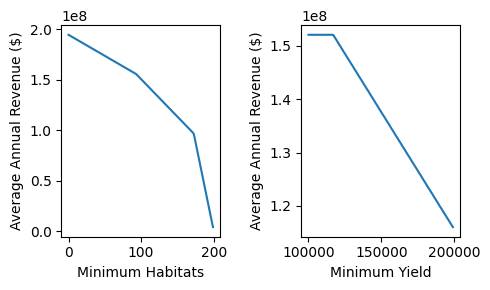

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

axes[0].plot(min_habs, [s.avg_annual_revenue for s in solutions_given_habs])
axes[0].set_xlabel('Minimum Habitats')
axes[0].set_ylabel('Average Annual Revenue ($)')

axes[1].plot(min_yield, [s.avg_annual_revenue for s in solutions_given_yield])
axes[1].set_xlabel('Minimum Yield')
axes[1].set_ylabel('Average Annual Revenue ($)')

# fig.suptitle("Revenue Falls with Stricter Constraints", y=0.95)
plt.tight_layout()

plt.savefig('figures/rev_under_constraints.png')

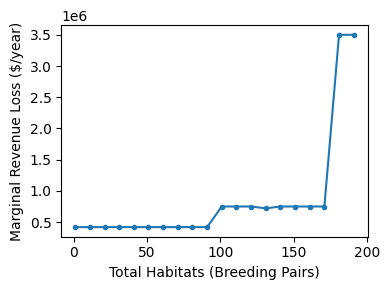

In [ ]:
rev_given_habs = np.array([s.avg_annual_revenue for s in solutions_given_habs])
marginal_cost_habitat = np.round(rev_given_habs[:-1] - rev_given_habs[1:], -4)
marginal_cost_habitat[marginal_cost_habitat > 999999] = np.round(marginal_cost_habitat[marginal_cost_habitat > 999999], -5)

plt.figure(figsize=(4, 3))
plt.plot(min_habs[1:][::10], marginal_cost_habitat[::10], marker=".")
plt.ylabel('Marginal Revenue Loss ($/year)')
plt.xlabel('Total Habitats (Breeding Pairs)')
# plt.title('Increasing Marginal Cost of Habitats')

plt.tight_layout()

plt.savefig('figures/marginal_cost_habitats.png')

In [ ]:
best = 0
for hab, cost in zip(min_habs[1:], marginal_cost_habitat):
    if cost > best:
        print(f"marginal cost of {hab}th habitat: {cost}")
        best = cost

marginal cost of 1th habitat: 420000.0
marginal cost of 93th habitat: 480000.0
marginal cost of 94th habitat: 650000.0
marginal cost of 95th habitat: 750000.0
marginal cost of 173th habitat: 2000000.0
marginal cost of 174th habitat: 3500000.0


/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_46078/1488189003.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], rotation = 45)


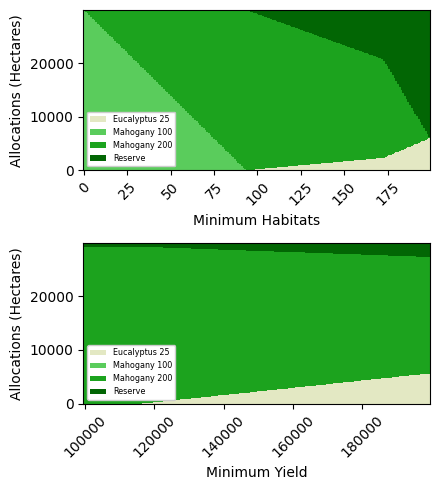

In [ ]:
from model.plot_utils import colors

def allocation_chart(x, solutions, ax=None, xlabel="", legend=True):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
    x = np.array(list(x))
    strategies = ["Eucalyptus 25", "Mahogany 100", "Mahogany 200", "Reserve"]

    allocation_changes = {}
    for strategy in strategies:
        allocation_changes[strategy] = np.array([s.allocations[strategy] for s in solutions])

    bottom = np.zeros(len(x))
    w = x[1] - x[0]
    for s in strategies:
        # assert x.shape == allocation_changes[s].shape, f"mismatch for {s}, {x.shape} vs {allocation_changes[s].shape}"
        ax.bar(x, allocation_changes[s], color=colors[s], label=s, bottom=bottom, width=w)
        bottom += allocation_changes[s]
    if legend:
        ax.legend(framealpha=1, fontsize="xx-small", loc="lower left")
    ax.margins(x=0, y=0)

    ax.set_xticklabels([int(i) for i in ax.get_xticks()], rotation = 45)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Allocations (Hectares)')
# rev_parrots = np.array([s.avg_annual_revenue for s in solutions_given_habs])
# mcost_parrots = rev_parrots[:-1] - rev_parrots[1:]
# plt.scatter(min_habs[:-1], mcost_parrots, s=1)

fig, axes = plt.subplots(2, 1, figsize=(4.5, 5))
# fig.suptitle("Only Eucalyptus Satisfies Stricter Constraints")
allocation_chart(min_yield, solutions_given_yield, ax=axes[1], xlabel="Minimum Yield")
allocation_chart(min_habs, solutions_given_habs, ax=axes[0], xlabel="Minimum Habitats")
plt.tight_layout()

/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_46078/1488189003.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) for i in ax.get_xticks()], rotation = 45)


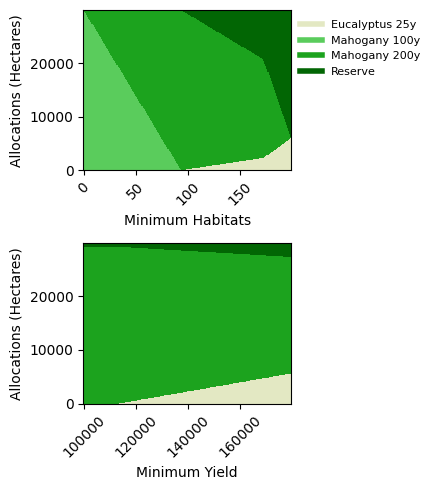

In [ ]:
from model.plot_utils import legend_content, legend_names
fig, axes = plt.subplots(2, 2, figsize=(4.5, 5), width_ratios=[1, 0.25])

# fig.suptitle("Only Eucalyptus Satisfies Stricter Constraints")
allocation_chart(min_habs, solutions_given_habs, ax=axes[0, 0], xlabel="Minimum Habitats", legend=False)
allocation_chart(min_yield, solutions_given_yield, ax=axes[1, 0], xlabel="Minimum Yield", legend=False)
axes[0, 1].axis('off')
axes[1, 1].axis('off')
axes[0, 1].legend(legend_content[:-2], legend_names[:-2], fontsize=8, frameon=False)
plt.tight_layout()

plt.savefig("figures/allocations_given_constraints.png")

# Layout

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


True

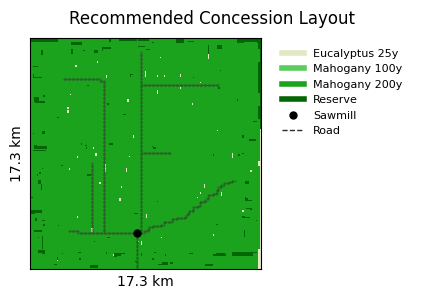

In [ ]:
from model.layout import make_layout, plot_map, anneal, plot_anneal_result
from model.layout_roads import make_roads

allocations = solve().allocations
layout = make_layout(allocations)

opt_result = anneal(layout)
roads = make_roads(opt_result.best_layout)

plot_map(opt_result.best_layout, roads=roads, title=None)
plt.savefig("figures/final_map.png")

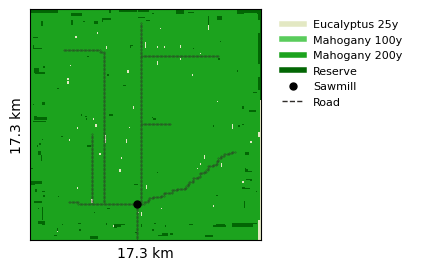

In [ ]:
plot_map(opt_result.best_layout, roads=roads, title=None)
plt.savefig("figures/final_map.png")